In [181]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json

In [182]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [183]:
raw_df = pd.read_csv("../log/stat.csv")
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df.head()

,time,level,file,line,msg,pkt_count,tcp_pkt_count_tot,udp_pkt_count_tot,icmp_pkt_count_tot,unsupported_pkt_count,...,install_buf_size,replied_flow_count_tot,replied_flow_count_tcp,replied_flow_count_udp,replied_flow_count_icmp,expired_pkt_count_tot,expired_pkt_count_tcp,expired_pkt_count_udp,expired_pkt_count_icmp,active_host_tbl_entry_count
0,0.000000,STATS,src/tsdn.c,470,stats,836,555.0,273.0,1.0,0.0,...,1.0,46.0,36.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000876,STATS,src/tsdn.c,488,pkt_processing_time,1000,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006392,STATS,src/tsdn.c,488,pkt_processing_time,2000,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.010022,STATS,src/tsdn.c,470,stats,2628,1645.0,971.0,1.0,0.0,...,1.0,146.0,99.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.011973,STATS,src/tsdn.c,488,pkt_processing_time,3000,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
stats_df = raw_df[raw_df['msg'] == 'stats']

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
print(timeout_df.head())

       time  sample_at  pkt_process_time
1  0.000876       1000              19.0
2  0.006392       2000              11.0
4  0.011973       3000              14.0
5  0.016937       4000              15.0
7  0.022224       5000              26.0
         time  timeout
25   0.080503    21600
51   0.160917    34730
77   0.241378    39530
100  0.311664    31698
125  0.392112    28630


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

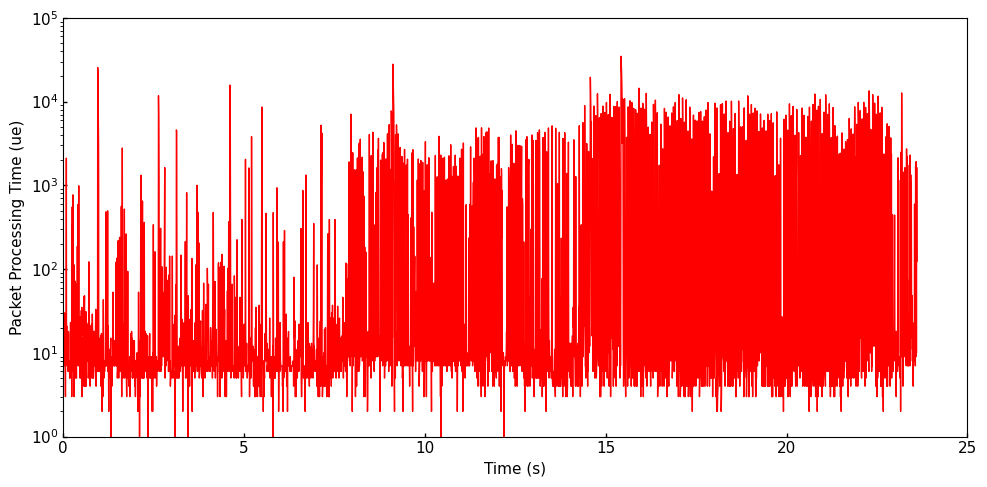

In [185]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              yscale='log',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (ue)')

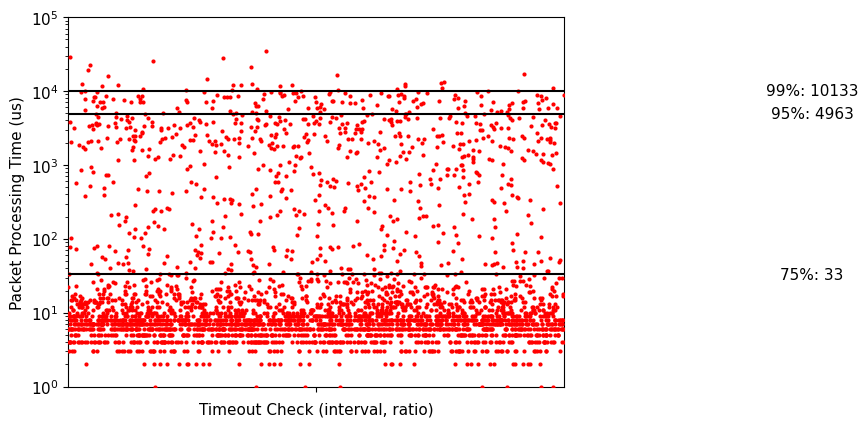

In [186]:
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (interval, ratio)')
plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

([Text(0.1628024193548387, 34414.60606060606, '75%: 34604'),
  Text(0.16270161290322582, 38427.57121212121, '95%: 39090'),
  Text(0.16265120967741936, 40356.617878787874, '99%: 39978')],
 [])

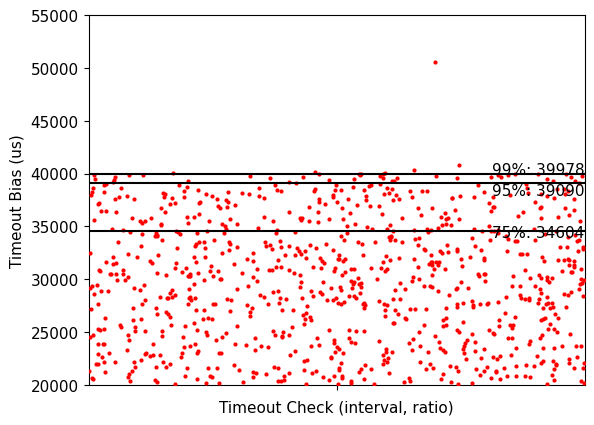

In [187]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (interval, ratio)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [188]:
from cycler import cycler

mcolor_lists = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

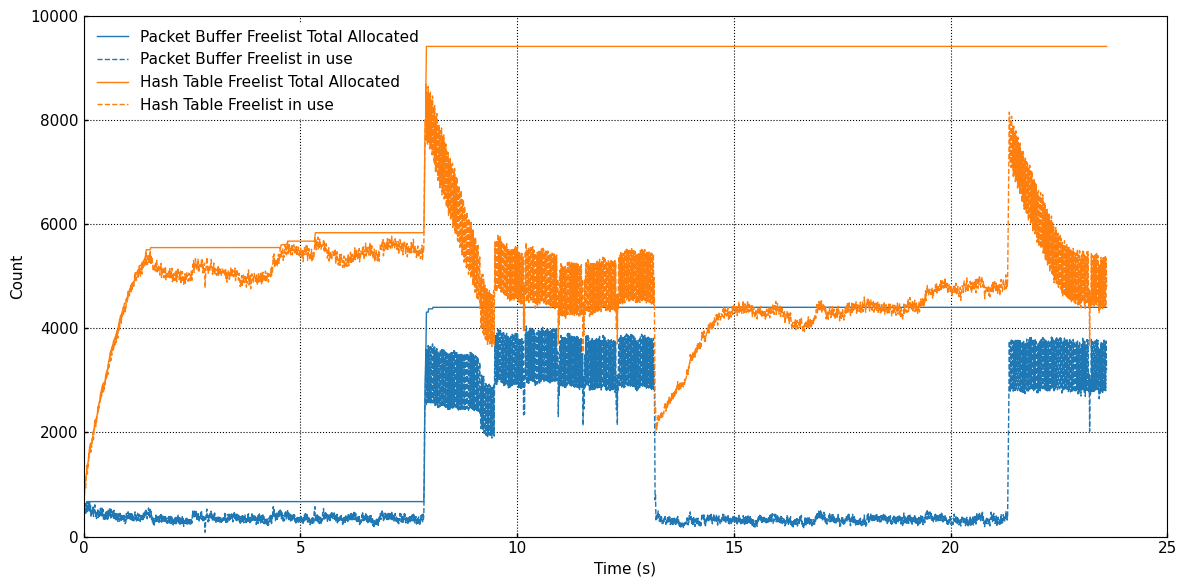

In [189]:
# buffered packet count

fastplot.plot([('Packet Buffer Freelist Total Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer Freelist in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Freelist Total Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table Freelist in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

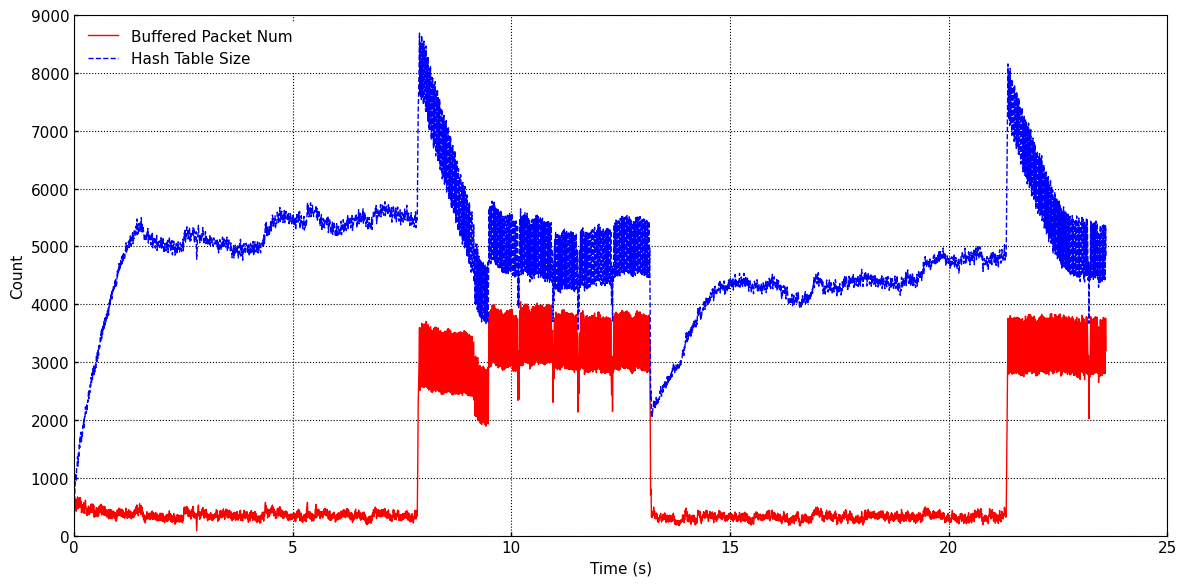

In [190]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


# Data Plane Resource Usage

## Table Entry Count

In [195]:
stats_df['install_buf_size']

0       1.0
3       1.0
6       1.0
9       1.0
11      1.0
       ... 
6494    1.0
6496    1.0
6501    0.0
6503    1.0
6506    0.0
Name: install_buf_size, Length: 2354, dtype: float64

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

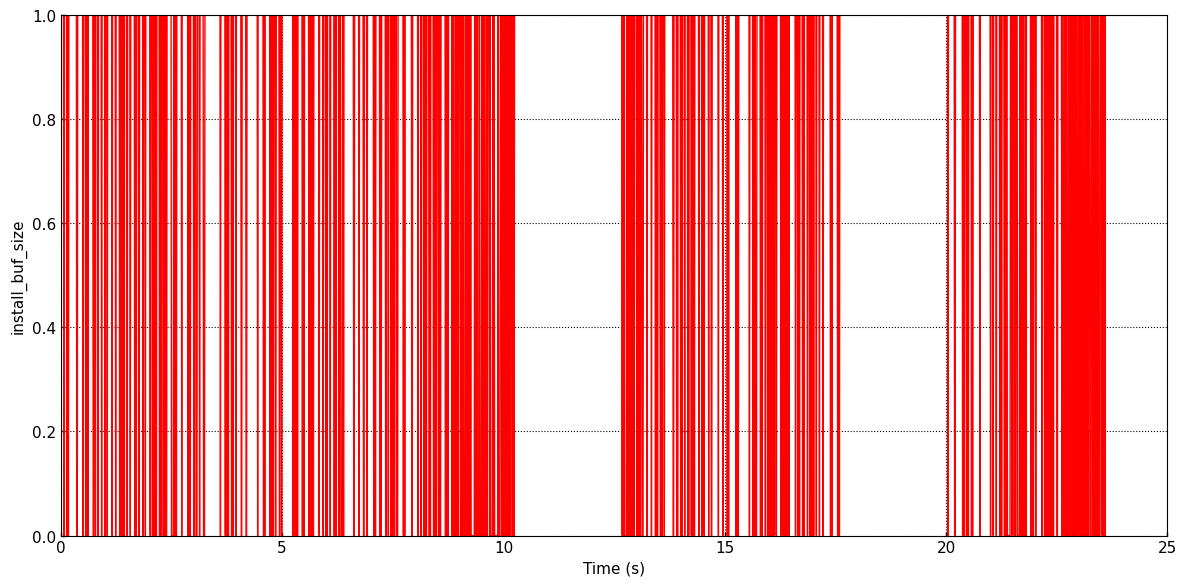

In [191]:
fastplot.plot((stats_df['time'], stats_df['install_buf_size']),
                None,
                mode='line',
                legend_loc='best',
                figsize=(12, 6), grid=True,
                xlabel='Time (s)', 
                ylabel='install_buf_size')

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

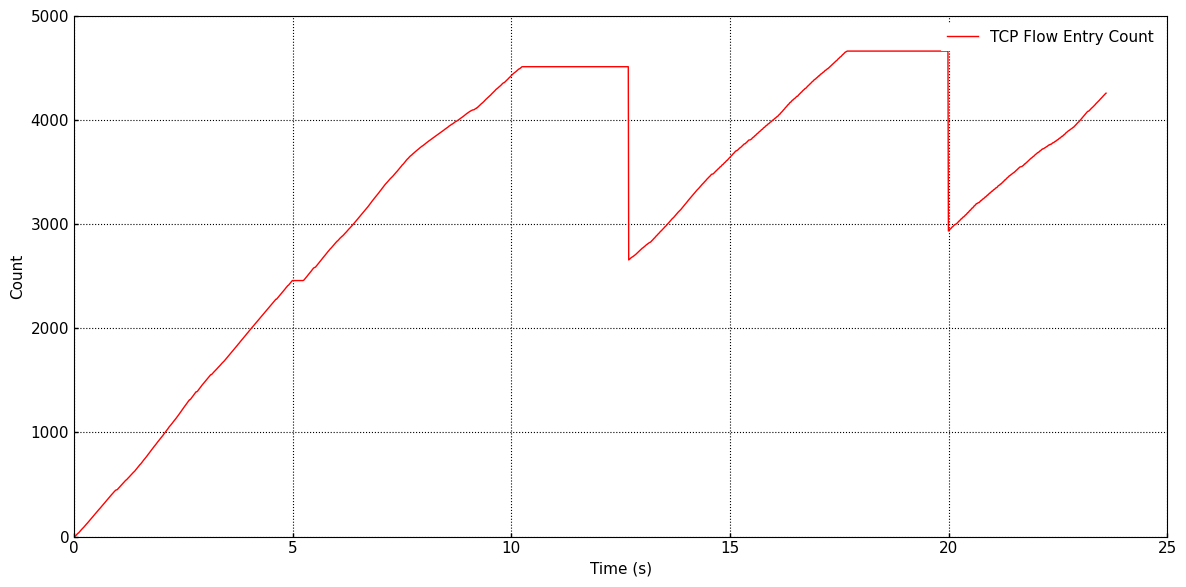

In [192]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [193]:
net_speed_df = []

with open('../log/speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            net_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

net_speed_df = pd.DataFrame(net_speed_df)
net_speed_df['rx_speed'] = net_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' Kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
net_speed_df['rx_speed'] = net_speed_df['rx_speed'].astype(float)
net_speed_df.head()

,time,rx_speed
0,2,0.00000
1,4,0.00000
2,6,0.00000
3,8,0.00000
4,10,0.23713


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

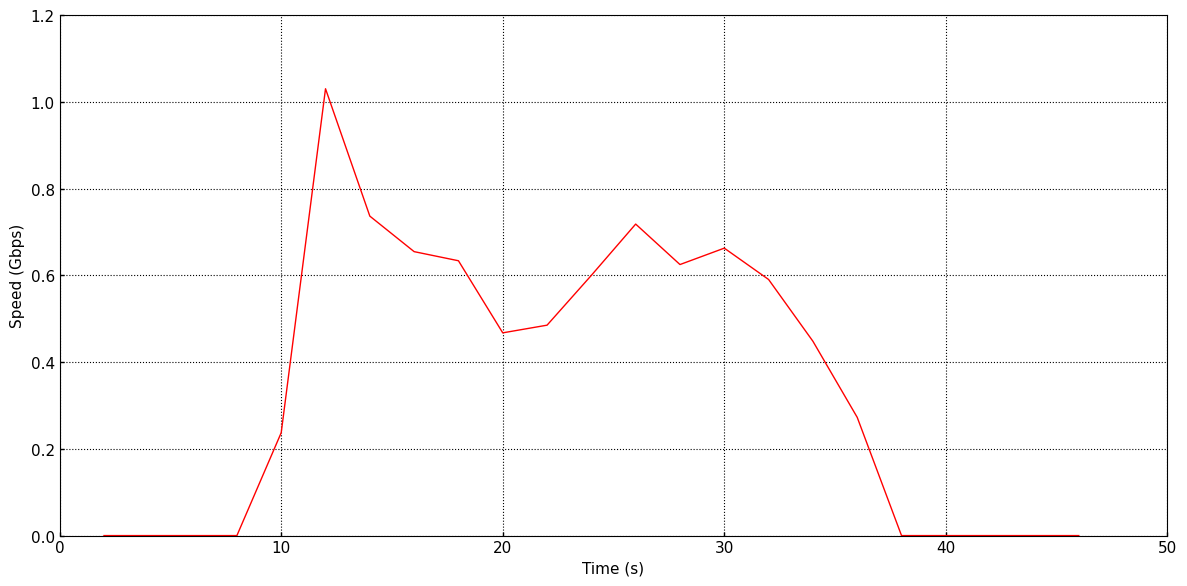

In [194]:
fastplot.plot((net_speed_df['time'], net_speed_df['rx_speed']),
                None,
                mode='line',
                legend=True, legend_loc='best',
                figsize=(12, 6), grid=True,
                xlabel='Time (s)', 
                ylabel='Speed (Gbps)')